# Working with raster data in python


## Table of Contents

1. [About the dataset](#dataset)<br>
2. [Part 1 - Weather maps with netCDF4 and matplotlib](#part1)<br>
    2.1. [Import packages](#import1)<br>
    2.2. [Load gridded data with netCDF4](#load1)<br>
    2.3. [Create a global map of the average temperature in January using matplotlib](#map1)<br>

3. [Part 2 - Weather maps with xarray and Cartopy](#part2)<br>
    3.1. [Import packages](#import2)<br>
    3.2. [Load gridded data with xarray](#load2)<br>
    3.3. [Create maps using xarray](#map21)<br>
    3.4. [Create maps using Cartoid](#map22)<br>


<a id="dataset"></a>
## About the dataset

With the gridded data from [CRU](http://www.cru.uea.ac.uk/data/) you will learn how to work with gridded historical data. 

The [dataset](https://crudata.uea.ac.uk/cru/data/temperature/#datdow) contains a 5&deg; by 5&deg; grid with absolute temperatures from 1961 to 1990. The data is represented in a [NetCDF](https://pro.arcgis.com/en/pro-app/help/data/multidimensional/what-is-netcdf-data.htm) format.

Download the following file, and store it locally or in object-store when working on the [IBM Data Science Experience](https://datascience.ibm.com/) :

* https://crudata.uea.ac.uk/cru/data/temperature/absolute.nc



<a id="part1"></a>
## Part 1 -  Weather maps with netCDF4 and matplotlib


In the first half of this tutorial, we will see how to use Python's [netCDF4](https://unidata.github.io/netcdf4-python/netCDF4/index.html) module to extract data from the dataset. 





<a id="import1"></a>
### 1. Import packages

Following is the explicit list of imports that we used through this notebook.  

In [2]:
import pandas as pd
import requests, json
from io import StringIO
from netCDF4 import Dataset
import numpy as np
import scipy
import matplotlib
from pylab import *
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
%matplotlib inline

We first import the dataset with a helper function that uses the project token created per instructions mentioned above. Import the `absolute.nc` file locally or add the below code by clicking on `Insert to code` below the file under the file in object-store. Then load the data and explore the variables and dimensions of the file. 



In [3]:

# define the helper function 
def download_file_to_local(project_filename, local_file_destination=None, project=None):
    """
    Uses project-lib to get a bytearray and then downloads this file to local.
    Requires a valid `project` object.
    
    Args:
        project_filename str: the filename to be passed to get_file
        local_file_destination: the filename for the local file if different
        
    Returns:
        0 if everything worked
    """
    
    project = project
    
    # get the file
    print("Attempting to get file {}".format(project_filename))
    _bytes = project.get_file(project_filename).read()
    
    # check for new file name, download the file
    print("Downloading...")
    if local_file_destination==None: local_file_destination = project_filename
    
    with open(local_file_destination, 'wb') as f: 
        f.write(bytearray(_bytes))
        print("Completed writing to {}".format(local_file_destination))
        
    return 0

In [4]:
download_file_to_local('absolute.nc', project=project)
cfile = "absolute.nc"

Attempting to get file absolute.nc
Downloading...
Completed writing to absolute.nc


<a id="load1"></a>
### 2. Load gridded data with netCDF4

 We then use netCDF4's *Dictionary* collection to analyse the data and its relations between the fields that consitute the netCDF file. 

In [5]:
dataset = Dataset(cfile)


To extract the data model version of the netCDF file, we use the *data_model* variable is used. The data model can be one of NETCDF3_CLASSIC, NETCDF4, NETCDF4_CLASSIC, NETCDF3_64BIT_OFFSET OR NETCDF3_63BIT_DATA.


In [6]:
print(dataset.data_model)

NETCDF3_CLASSIC


*dimensions* returns a dictionary with variables names from the dataset mapped to instances of the Dimensions class. It provides the name of the variable along with its size.

In [7]:
print(dataset.dimensions)

OrderedDict([('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 36
), ('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 72
), ('time', <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 12
)])


*variables* returns a dictionary that maps the variable names from the dataset as instances of *Variable* class.

In [8]:
print(dataset.variables)

OrderedDict([('tem', <class 'netCDF4._netCDF4.Variable'>
int16 tem(time, lat, lon)
    long_name: CRU_Global_1961-1990_Mean_Monthly_Surface_Temperature_Climatology
    units: celsius
    scale_factor: 0.01
    valid_min: -9000
    missing_value: -9999
unlimited dimensions: 
current shape = (12, 36, 72)
filling on, default _FillValue of -32767 used
), ('lat', <class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    units: degrees_north
unlimited dimensions: 
current shape = (36,)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('lon', <class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    units: degrees_east
unlimited dimensions: 
current shape = (72,)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('time', <class 'netCDF4._netCDF4.Variable'>
int16 time(time)
    units: months
unlimited dimensions: 
current shape = (12,)
filling on, default _FillValue of -32767 used
)])


Below is an example of how variables from the dataset can be accessed as keys of the dictionary returned in the line above. 

In [9]:
lons = dataset.variables['lon'][:] 
print("Shape of longitude data : ",np.shape(lons))

lats = dataset.variables['lat'][:] 
print("Shape of latitude data : ",np.shape(lats))

time = dataset.variables['time'][:] 
print("Shape of time data : ",np.shape(time))

temperature = dataset.variables['tem'][:,:,:]
print("Shape of temperature data : ",np.shape(temperature))

Shape of longitude data :  (72,)
Shape of latitude data :  (36,)
Shape of time data :  (12,)
Shape of temperature data :  (12, 36, 72)


<a id="map1"></a>
### 3. Create a global map of the average temperature in January using matplotlib


We will now see how matplotlib and its extensions can be used to plot 2D maps in Python. Here we use the matplotlib [basemap](https://matplotlib.org/basemap/users/intro.html) toolkit. To map the points on a 2D surface, basemap supports 24 different types of [projections](https://matplotlib.org/basemap/users/mapsetup.html). In this example Miller Projections is used. Miller projections are generally used for wall maps rather than as navigational maps. Details of Miller projections can be found [here](https://matplotlib.org/basemap/users/mill.html). llcrnrlon, llcrnrlat refer to longitude and latitude of lower left hand corner of the desired map domain(degrees) respectively.  urcrnrlon, urcrnrlat refer to longitude and latitude of lower right hand corner of the desired map domain(degrees) respectively. 

/opt/conda/envs/Python36/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


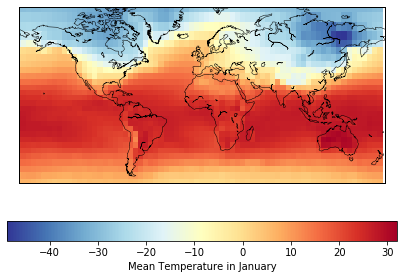

In [10]:
# define the area to plot and projection to use
m =\
Basemap(llcrnrlon=-180,llcrnrlat=-60,urcrnrlon=180,urcrnrlat=80,projection='mill')

# covert the latitude, longitude and temperatures to raster coordinates to be plotted
t1=temperature[0,:,:]
t1,lon=addcyclic(t1,lons)
january,longitude=shiftgrid(180.,t1,lon,start=False)
x,y=np.meshgrid(longitude,lats)
px,py=m(x,y)

palette=cm.RdYlBu_r
rmin=-30.
rmax=30.
ncont=20
dc=(rmax-rmin)/ncont
vc=arange(rmin,rmax+dc,dc)
pal_norm=matplotlib.colors.Normalize(vmin = rmin, vmax = rmax, clip = False)

m.drawcoastlines(linewidth=0.5)
m.drawmapboundary(fill_color=(1.0,1.0,1.0))
cf=m.pcolormesh(px, py, january, cmap = palette)
cbar=colorbar(cf,orientation='horizontal', shrink=0.95)
cbar.set_label('Mean Temperature in January')
tight_layout()


*addcyclic* adds a column of longitude to a set of data. In the code below we see that the longitude array is added to an array containing temperature entries. *shiftgrid* moves all longitudes and data east or west. The *meshgrid* method returns co-ordinate matrictes from one dimentional coordinate arrays. In the code below, we use meshgrid to convert longitude and latitude arrays into x and y coordinate arrays. 

<a id="part2"></a>
## Part 2 - Weather maps with xarray and Cartopy

In the second half of tutorial, we will see how to use [xarray](http://xarray.pydata.org/en/stable/) to process the netCDF data. xarray is useful with analysing multidimensional arrays. It shares functionalities from pandas and NumPy. xarray has proven to be a robust library to handle netCDF files. 


<a id="import2"></a>
### 1. Import packages

Following snippet shows the required imports that needs to be done to be able to run the notebook. 

In [11]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

<a id="load2"></a>
### 2. Load gridded data with xarray

We then open and load the dataset using xarray. 

In [12]:
dataset = xr.open_dataset(cfile)

xarray supports the following data structures : 

- *DataArray* which is a multidimensional array 
-  *Dataset* which is a dictionaty of multiple DataArray objects.

 netCDF data is represented as a Dataset in xarray. 

In [13]:
dataset.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  (lat: 36, lon: 72, time: 12)
Coordinates:
  * lat      (lat) float32 87.5 82.5 77.5 72.5 67.5 ... -72.5 -77.5 -82.5 -87.5
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * time     (time) int16 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    tem      (time, lat, lon) float32 ...>

*dims* returns the value of the x, y and z coordinates. 

In [14]:
dataset.dims

Frozen(SortedKeysDict({'time': 12, 'lat': 36, 'lon': 72}))

*coords* returns just the coordinates section from the *values* variable we saw above.

In [15]:
dataset.coords

Coordinates:
  * lat      (lat) float32 87.5 82.5 77.5 72.5 67.5 ... -72.5 -77.5 -82.5 -87.5
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * time     (time) int16 1 2 3 4 5 6 7 8 9 10 11 12


Since xarray is an extension to pandas, it offers a method which enables us to convert the dataset to a dataframe. 

In [16]:
df = dataset.to_dataframe()
df.head()

tem
lat  lon    time           
87.5 -177.5 1    -30.099998
            2    -30.500000
            3    -30.500000
            4    -22.199999
            5     -9.000000

In [17]:
df.describe()

,tem
count,31104.000000
mean,4.658268
std,21.872236
min,-70.299995
25%,-6.600000
50%,10.200000
75%,23.000000
max,35.700001


<a id="map21"></a>
### 3. Create maps using xarray
xarray also supports plotting fuctionalities by extending the *matplotlib* library. DataArray objects can be plotted using xarray libraries. To plot Dataset objects, the relevant DataArrays or dimensions needs to be accessed. 

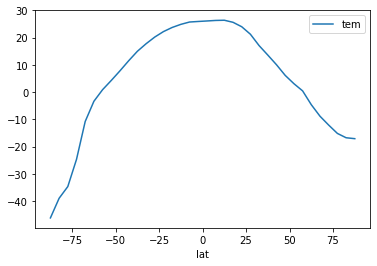

In [18]:
dataset.mean(dim=['time','lon']).to_dataframe().plot()

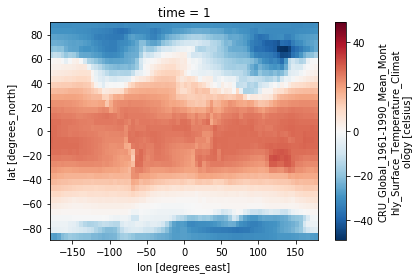

In [19]:
dataset.tem[0].plot()

<a id="map22"></a>
### 4. Create maps using Cartopy 

[Cartopy](https://scitools.org.uk/cartopy/docs/latest/) is one of the several  plotting applications that are compatible with xarray. Few others are Seaborn, HoloViews and GeoViews.

Below is a simple example of using cartopy to create visualizations. We compare the Molleweide projection vs the Miller projection. A complete list of projections can be found [here](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html)

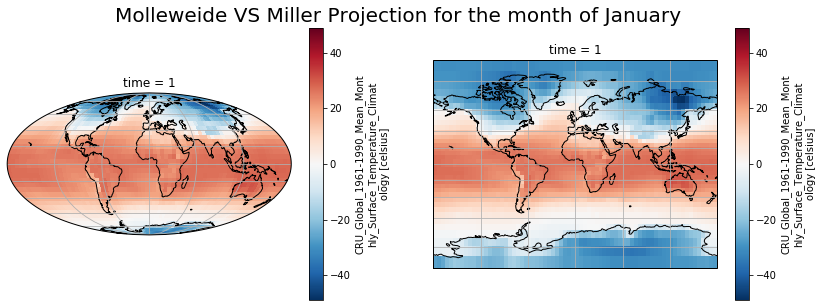

In [20]:
f = plt.figure(figsize=(14,5))
plt.title("Molleweide VS Miller Projection for the month of January", fontsize=20)
plt.axis('off')
ax1 = f.add_subplot(1,2,1, projection = ccrs.Mollweide())
ax2 = f.add_subplot(1,2,2, projection = ccrs.Miller())
ax1.coastlines()
ax1.gridlines()
ax2.coastlines()
ax2.gridlines()

dataset.tem[0].plot(ax=ax1, transform=ccrs.PlateCarree())
dataset.tem[0].plot(ax=ax2, transform=ccrs.PlateCarree())

Following is a heat map comparing the intensity of temperatures between the month of January and June.

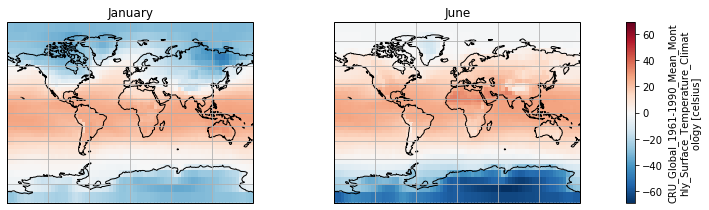

In [21]:
proj = ccrs.Miller()
jan_june = dataset.tem.isel(time=[0,5])
months = ['January','June']
i = 0

p = jan_june.plot(transform=ccrs.PlateCarree(),
             col='time', col_wrap=2, 
             aspect=dataset.dims['lon'] / dataset.dims['lat'],
             subplot_kws={'projection': proj})


for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()
    ax.set_title(months[i])
    i = i+1
    
    

### Author
Margriet Groenendijk is a Data & AI Developer Advocate for IBM. She develops and presents talks and workshops about data science and AI. She is active in the local developer communities through attending, presenting and organising meetups. She has a background in climate science where she explored large observational datasets of carbon uptake by forests during her PhD, and global scale weather and climate models as a postdoctoral fellow. 

Samaya Madhavan is an Advisory Software Engineer with IBM where she currently publishes content that are related to machine learning and deep learning. She is also a full stack software developer, experienced in offering AI based solutions within the healthcare domain. Samaya has her Bachelor of Engineering in Computer Science from College of Engineering, Guindy and her Master of Science in Computer Science from University of Texas at Arlington. She is an ardent learner and a very passionate algorithm solver.

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.